In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from data_parsing import DataParser
import seaborn as sb
import os
import scipy.sparse

### sb seaborn library sets the aesthetic for the charts with seaborn library

### comment out either AM or LaaL depending on what you want to run.  Make sure to use correct csv data files for subsequent analysis

In [7]:
sb.set(context='notebook', style='white', palette='deep', font='Times', font_scale=1, color_codes=True, rc=None)

## AM dataset
# dataAM = DataParser('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
# trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
# id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')

## LaaL dataset
dataLaaL = DataParser('data/MITxPRO+LASERxB1+1T2019/LaaL', 'data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
# trajectories, status = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL', 'data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
# id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')

In [8]:
# trajectories = dataAM.trajectories
trajectories = dataLaaL.trajectories

In [9]:
vectorizer = CountVectorizer(ngram_range=[2,2])
url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())

6199

In [10]:
def get_medoid_clusters(k, url_subset, traj_subset):
    kmedoids = KMedoids(n_clusters = k).fit(url_subset)
    kmedoids.labels_
    
    labels = pd.DataFrame(kmedoids.labels_)
    labels['index'] = traj_subset.index
    labels['is exemplar'] = 0
    for exemplar in kmedoids.medoid_indices_:
        labels.iloc[exemplar, 2] = 1
    #labels.to_csv('MITxPRO+LASERxB1+1T2019_kmedoids {} clusters.csv'.format(k), header = ['cluster id', 'user id', 
                                                                                     #'is exemplar'], index = False)  
    clusters = []
    cluster_id = []
    cluster_len = []
    for i in range(k):
        clusters.append([])
        cluster_id.append([])
        cluster_len.append([])
        
    for i, label in enumerate(kmedoids.labels_):
        clusters[label].append(traj_subset.index[i])
        cluster_id[label].append(i)
        cluster_len[label].append(len(traj_subset.iloc[i]))
    print([np.mean(x) for x in cluster_len])
#     fig = plt.figure(figsize=(10,6))
#     for i in range(k):
#         sb.distplot(cluster_len[i], bins=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500],
#                    kde=False)
#         plt.title('LaaL 5-cluster distribution')
#         plt.xlabel('Number of clicks in trajectory')
#         plt.ylabel('Trajectories')
#     fig.legend(labels=range(k))
#     plt.show()
    return cluster_id


	 2
[169.53846153846155, 662.0285714285715]
[655.3414634146342, 173.0]
[561.0, 636.8]
[660.7567567567568, 129.36363636363637]
[597.4318181818181, 546.25]
[577.1744966442953, 540.0760869565217]
-0.007353846107286977 0.006691022295650816

	 3
[169.53846153846155, 679.3333333333334, 603.625]
[647.3939393939394, 173.0, 688.125]
[554.5, 670.5, 668.0]
[664.7647058823529, 615.3333333333334, 129.36363636363637]
[614.2439024390244, 546.25, 367.6666666666667]
[544.8181818181819, 504.6375, 734.8]
-0.006269775578977833 0.006682808722991249

	 4
[656.0, 632.4, 683.4166666666666, 169.53846153846155]
[613.1538461538462, 663.5238095238095, 688.125, 111.66666666666667]
[519.5897435897435, 554.3333333333334, 502.0, 975.6]
[686.6896551724138, 614.5, 129.36363636363637, 550.8333333333334]
[615.5897435897435, 546.25, 367.6666666666667, 588.0]
[477.46478873239437, 524.2115384615385, 690.5142857142857, 745.1612903225806]
-0.006534684912095745 0.006610230797810916

	 5
[656.0, 632.4, 683.4166666666666, 375.3

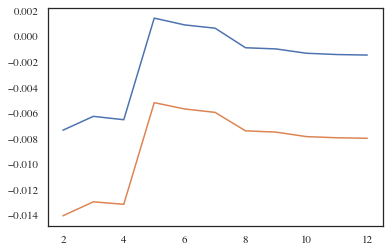

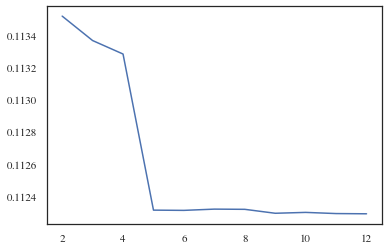

In [11]:
b = 5
x = trajectories
subset_len = int(np.floor(len(x)/b))
#index = np.arange(scipy.sparse.csr_matrix.getnnz(url_counts))
index = np.arange(url_counts.shape[0])
np.random.shuffle(index)

gaps = []
w_history = []
stds = []
ks = [2,3,4,5,6,7,8,9,10,11,12]
for k in ks:
    print('\n\t', k)
    # Calc intercluster variance for each subset, W_kB
    W_kb = [] 
    for i in range(b):
        ii = index[i*subset_len: (i+1)*subset_len]
        #url_subset = get_medoid_clusterurl_dataset[ii]
        url_subset = url_counts[ii]
        traj_subset = trajectories.iloc[ii]
        
        cluster_id = get_medoid_clusters(k, url_subset, traj_subset)
        cluster_variances = []
        for i in range(k):
            cluster_variances.append(url_subset.todense()[cluster_id[i]].var())
        cluster_variances = np.array(cluster_variances)
        cluster_counts = np.array([len(x) for x in cluster_id])
        W_kb.append((cluster_variances*cluster_counts/subset_len).sum())

    W_kb = np.array(W_kb)
        
    # Calc intercluster variance of full dataset, W_k
    cluster_id = get_medoid_clusters(k, url_counts, trajectories)
    cluster_variances = []
    for i in range(k):
        cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
    cluster_variances = np.array(cluster_variances)
    cluster_counts = np.array([len(x) for x in cluster_id])
    W_k = (cluster_variances*cluster_counts/len(trajectories)).sum()
    w_history.append(W_k)

    # Final Calcs
    gap_k = 1/b * np.sum(np.log(W_kb)-np.log(W_k))
    std_k = np.std(W_kb) 
    gaps.append(gap_k)
    stds.append(std_k)
    print(gap_k, std_k)
    
plt.plot(ks, gaps)
plt.plot(ks, np.array(gaps)-np.array(stds))
plt.show()
plt.plot(ks, w_history)

In [6]:
#trajectories

In [5]:
# variance_by_k = []
# ks = list(range(2,7))
# for k in ks:
#     cluster_id = get_medoid_clusters(k)
    
#     cluster_variances = []
#     for i in range(k):
#         cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
#     cluster_variances = np.array(cluster_variances)
#     cluster_counts = np.array([len(x) for x in cluster_id])
#     variance_by_k.append((cluster_variances*cluster_counts/len(trajectories)).sum())
#     print(cluster_variances)

In [45]:
# temp = pd.read_csv('MITxPRO+AMxB+1T2018_kmedoids 7 clusters.csv')
# temp[temp['is exemplar']==1]

Text(0.5, 1.0, 'K-medoid clustering for LaaL course')

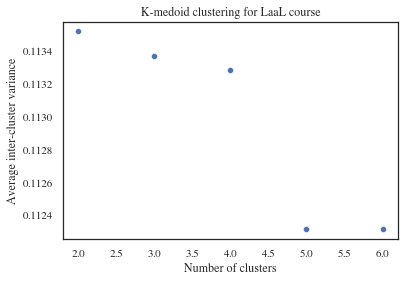

In [17]:
sb.scatterplot(ks, variance_by_k, x_bins=[0,2,3,4,5,6])
plt.xlabel('Number of clusters')
plt.ylabel('Average inter-cluster variance')
plt.title('K-medoid clustering for LaaL course')

In [10]:
#status = id_and_performance[id_and_performance['certGrp']== 'Certified (< 65% Grade)']

## 'cluster_df' takes csv file path for a cluster for performance stats in given cluster
# cluster_df = pd.read_csv('')
# performance_df = pd.merge(cluster_df, id_and_performance, left_on='user id', right_on='id')
# performance_df['cluster id'] = pd.Categorical(performance_df['cluster id'])
# performance_table = performance_df.groupby(['cluster id','certGrp'],
#                                            as_index=False, observed=False).count()[['cluster id', 'certGrp', 'id']]
# performance_table.columns = ['cluster id', 'certificate status', 'count']
# performance_table

In [12]:
# LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
# LaaL_edelist[:5]